In [ ]:
from setup import *

inc_judge_cost = True
num_sessions = 4
workload = 5
coverage = 4

posters_to_sessions_attempts = 10
judges_to_posters_attempts = 3


adjacency_data = pd.DataFrame.from_csv('adjacency.csv')
adjacency_data.index = adjacency_data.index.str.lower()
adjacency_data.columns = adjacency_data.columns.str.lower()

judge_data = pd.DataFrame.from_csv('judges.csv')
project_data = pd.DataFrame.from_csv('projects.csv')
def make_df(data):
    df = pd.DataFrame()
    df['name'] = (data['LAST NAME'] + ', ' + data['FIRST NAME']).str.lower()
    df['univ'] = data['INSTITUTION'].str.lower().astype('category')
    df['cat'] = data['CATEGORY'].str.lower().astype('category')
    df['field'] = data['SUBFIELD'].str.lower().astype('category')
    df['ses0'] = data['ses0']
    df['ses1'] = data['ses1']
    df['ses2'] = data['ses2']
    df['ses3'] = data['ses3']
    
    return df.sort_values('field')

judges = make_df(judge_data)
judges.index.names = ['judge id']
judges['mobile'] = judge_data['MOBILE COMFORT LEVEL']
projects = make_df(project_data)
projects.index.names = ['proj id']
projects['type'] = project_data['PRESENTATION TYPE']
projects['ses'] = 999

projects.sort_values(['field'],inplace=True)
judges.sort_values(['field'],inplace=True)
    
### Compute field distance matrix
def show():
    print()
    print("k=%d"%k)
    print("P")
    display(P,'all')
    print("dist")
    display(dist,'all')

D = adjacency_data.copy().values.astype(int)
T = adjacency_data.copy().values.astype(float)
s = T.sum(axis=1, keepdims=True)
T /= s
P = T.copy()

k = 1
for k in range(2,50):
    P = P.dot(T)
    # Write k in all entries of D that are 0 and the corresponding entry of P just became non-zero
    D[((D==0) & (P>0))] = k
    if(D.min() > 0): #break once Dist is full
        break
D[D==0] = 999
D[np.diag_indices_from(D)] = 0

dist = adjacency_data.copy()
dist[:] = D
dist.loc[:,'doctoral'] = np.nan
dist.loc['doctoral',:] = np.nan

field_incompat = np.array([[dist.loc[jf,pf] for pf in projects['field']] for jf in judges['field']]).astype(float)
univ_match = np.array([[ju == pu for pu in projects['univ']] for ju in judges['univ']])
field_incompat[univ_match] = np.nan
field_incompat = pd.DataFrame(field_incompat, index=judges.index, columns=projects.index)

sessions = ['ses0','ses1','ses2','ses3']
poster_idx = projects['type'] == 'Poster Presentation'
projects.loc[poster_idx,'type'] = 'poster'
posters = projects.loc[poster_idx].copy()

oral_idx = projects['type'] == 'Oral Presentation (Undergraduate and Masters Social Sciences Only)'
projects.loc[oral_idx,'type'] = 'oral'
orals = projects.loc[oral_idx].copy()
orals['rm'] = None

doc_idx = projects['type'] == 'Doctoral - Lightning Round Oral Presentation Competition'
projects.loc[doc_idx,'type'] = 'doctoral'
docs = projects.loc[doc_idx].copy()
docs['ses'] = 0
docs['rm'] = docs['ses0']

for (i,s) in enumerate(sessions):
    idx = orals[s].notnull()
    orals.loc[idx,'ses'] = i
    orals.loc[idx,'rm'] = orals.loc[idx,s]
    
    
    posters = posters.drop(s,1,errors='ignore')
    orals = orals.drop(s,1,errors='ignore')
    docs = docs.drop(s,1,errors='ignore')

def f(x):
    y = x.value_counts(sort=True)
    y = y[y>0]
    y.sort_values()
    return y

pf = projects.groupby('field')['type'].apply(f).unstack()
pf['total'] = pf.sum(axis=1)
jf = f(judges['field'])
jf.name = 'judges'
pjf = pd.concat([pf,jf],axis=1).fillna(0).astype('int')

# display(dist, where='popup', name='adjacency')
# display(field_incompat, where='popup', name='field_incompat')

# display(posters.groupby('field')['cat'].apply(f), where='popup', name='field_cat')
# display(projects.groupby(['type','cat'])['field'].apply(f), where='popup', name='by_type')
# display(pjf, where='popup', name='by_field')


num_judges = len(judges)
num_posters = len(posters)
fi_best = 99999

blank =  {'posters_to_sessions': []
         ,'judges_to_posters' : [[]]*num_sessions
         ,'fi':[99999]*num_sessions
         }
blank['fi_tot'] = sum(blank['fi'])
best = copy.deepcopy(blank)
intl_judges = judges['univ'] == "texas a&m international university"
for ps in range(posters_to_sessions_attempts):
    poster_grps = posters.groupby(['field'])
    curr = copy.deepcopy(blank)
    curr['posters_to_sessions'] = poster_grps.transform(lambda x: np.random.permutation(x))#.join(projs[['atype','field']])    
    curr['posters_to_sessions'] = pd.concat([curr['posters_to_sessions'],posters['field']],axis=1)
    curr['posters_to_sessions']['ses'] = np.arange(num_posters) % num_sessions
    intl0 = curr['posters_to_sessions'].query('(ses == 0) & (univ == "texas a&m international university")')

    for (id_a,p) in intl0.iterrows():
        f = p['field']
        ses_a = p['ses']
        reps = curr['posters_to_sessions'].query('(ses != 0) & (univ != "texas a&m international university") & (field == @f)')
        id_b = reps.index[0]
        ses_b = curr['posters_to_sessions'].loc[id_b,'ses']
        curr['posters_to_sessions'].loc[id_a,'ses'] = ses_b
        curr['posters_to_sessions'].loc[id_b,'ses'] = ses_a
        
    for ses in range(num_sessions):
#         print("    optimizing session %d"%ses)
        post = curr['posters_to_sessions'].query('ses == @ses')
        c = 'ses'+str(ses)
        orals_judges = judges[c].notnull()

        fi_source = field_incompat.loc[:, post.index]
        for jp in range(judges_to_posters_attempts):
#             print("        judges to posters attempt %d"%jp)
            
            assign = fi_source.copy()
            assign[:] = np.nan
            fi_rec = fi_source.copy()
            fi_rec.loc[intl_judges,:] = np.nan
            fi_rec.loc[orals_judges,:] = np.nan
            if(ses <=1):
                fi_rec.loc['R_qVmiVRWiX1daU5r',:] = np.nan  # Anja Schulze late

            judge_work = assign.iloc[:,0].copy()
            judge_work[:] = workload            
            judge_work = judge_work.astype(int)
#             judge_work.loc[intl_judges] = np.nan
#             judge_work.loc[orals_judges] = np.nan
#             display(judge_work.loc[intl_judges])
#             display(judge_work.loc[orals_judges])
            
            poster_coverage = assign.iloc[0,:].copy()
            poster_coverage[:] = coverage
            poster_coverage = poster_coverage.astype(int)
            
            while True:
                urgency = fi_rec.mean(axis=0, skipna=True)
                urg_max = urgency.max(skipna=True)
                if(np.isnan(urg_max) == True):
#                     print("no posters left")
                    break
                urg_post = urgency[urgency >= urg_max].index
                if(len(urg_post) == 1):
                    urg_post = urg_post[0]
                else:
                    urg_post = np.random.choice(urg_post)
                col = fi_rec[urg_post]
                fi_min = col.min(skipna=True)
                if(np.isnan(fi_min) == True):
#                     print("no judges left")
                    break
        
                best_judge = col[col <= fi_min].index
                if(len(best_judge) == 1):
                    best_judge = best_judge[0]
                else:
                    best_judge = np.random.choice(best_judge)
                    
                assign.loc[best_judge,urg_post] = fi_source.loc[best_judge,urg_post]
                
                if(inc_judge_cost == True):
                    fi_rec.loc[best_judge,:] += 1
                fi_rec.loc[best_judge,urg_post] = np.nan

                poster_coverage[urg_post] -= 1
                if(poster_coverage[urg_post] <= 0):
                    fi_rec.loc[:,urg_post] = np.nan

                judge_work.loc[best_judge] -= 1
                if(judge_work[best_judge] <= 0):
                    fi_rec.loc[best_judge,:] = np.nan

                


            fi_ses = np.nansum(assign)
#             print("        completed judge to proj %d"%jp)
#             print("        new fi_ses = %f"%fi_ses)
            if(fi_ses < curr['fi'][ses]):
#                 print("        better than old fi_ses_best = %f"%curr['fi'][ses])
                curr['fi'][ses] = fi_ses
                curr['judges_to_posters'][ses] = assign
#             else:
#                 print("        not better than old fi_ses_best = %f"%curr['fi'][ses])
#             print()
    curr['fi_tot'] = sum(curr['fi'])
#     print("    completed posters to sessions %d"%ps)
    print("    new fi_tot = %f"%curr['fi_tot'])    
    if(curr['fi_tot'] < best['fi_tot']):
        print("    better than old fi_tot best = %f"%best['fi_tot'])
        best = copy.deepcopy(curr)
    else:
        print("    not better than old fi_best = %f"%best['fi_tot'])        

,0,1,2,3
univ,,,,
prairie view a&m university,5,7,6,6
tarleton state university,14,9,15,18
texas a&m international university,0,10,4,4
texas a&m university - central texas,0,0,1,1
texas a&m university - commerce,9,8,5,8
texas a&m university - corpus christi,5,2,2,2
texas a&m university - kingsville,6,7,7,6
texas a&m university - san antonio,4,1,3,0
texas a&m university - texarkana,2,1,1,1


,name,univ,cat,field,ses0,ses1,ses2,ses3,mobile,0,1,2,3,tot_work
judge id,,,,,,,,,,,,,,
R_2PbwYq9uhrRSRwT,"weitman, catheryn",texas a&m international university,education,education,X,C,NaN,NaN,6.000,10,4,0,0,14
R_3lyjq7rnbqKG0LE,"huber, tonya",texas a&m international university,education,education,X,NaN,NaN,C,4.000,10,0,0,4,14


Field Incompatibilty by poster


,field_incompatibilty
count,187.000
mean,3.043
std,1.455
min,0.000
25%,2.000
50%,3.000
75%,4.000
max,8.000


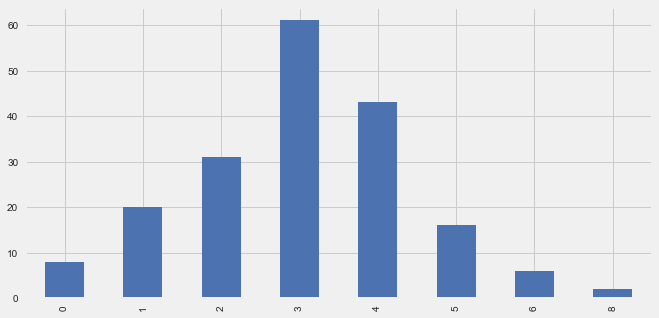

Judge Workload


,tot_work
count,93.000
mean,10.688
std,4.062
min,0.000
25%,8.000
50%,11.000
75%,14.000
max,20.000


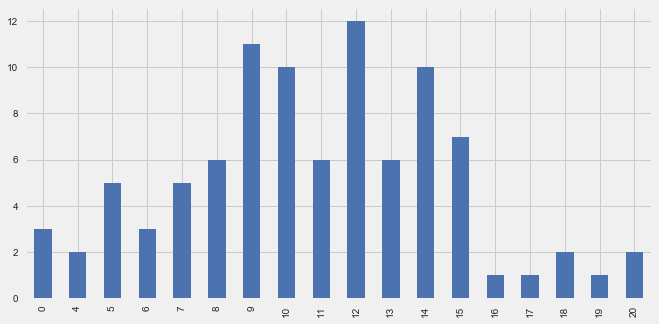

PermissionError: [Errno 13] Permission denied: 'judge-workload.xls'

In [25]:
try:
    del posters
except:
    pass

posters_final = best['posters_to_sessions'].copy()
judges_to_posters = best['judges_to_posters'].copy()
fi = pd.concat([jp.sum(axis=0) for jp in judges_to_posters]).astype(int)
posters_final['field_incompatibilty'] = fi

def get_assign(row):
    x = pd.Series(row.dropna().index)
    return x

def append_assignments(raw,assignments):
    attrs = ['name','univ','field']
    jud = pd.concat([judges.loc[col[1],attrs].reset_index() for col in assignments.items()], axis=1)
    jud = jud.rename(columns = lambda x : 'judge_' + str(x))
    jud.index = assignments.index    
    return pd.concat([raw,jud],axis=1)
    
posters_assignments = pd.concat([jp.T.apply(get_assign,axis=1) for jp in judges_to_posters])
posters_final = append_assignments(posters_final,posters_assignments)
# display(posters_final.sort_values(by='field_incompatibilty',ascending=False),where='popup',name='posters')


doc_dum = pd.get_dummies(docs['rm'])
jud_dum = pd.get_dummies(judges['ses0'])[['X','Y','Z']]
judges_to_docs = jud_dum.dot(doc_dum.T).replace(0,np.nan)
docs_assignments = judges_to_docs.T.apply(get_assign,axis=1)
docs_final = append_assignments(docs,docs_assignments)
# display(docs_final,where='popup',name='doc')

judges_to_orals = []
orals_assignments = []
for ses in range(num_sessions):
    o = orals.query('ses == @ses')
    oral_dum = pd.get_dummies(o['rm'])
    jud_dum = pd.get_dummies(judges['ses'+str(ses)])[['A','B','C']]    
    jo = jud_dum.dot(oral_dum.T).replace(0,np.nan)
    judges_to_orals.append(jo)
    orals_assignments.append(jo.T.apply(get_assign,axis=1))#.rename(columns = lambda x : 'judge_' + str(x)))
orals_assignments = pd.concat(orals_assignments, axis=0)
orals_final = append_assignments(orals,orals_assignments)
# display(orals_final,where='popup',name='orals')


posters_work = [jp.apply(get_assign,axis=1).rename(columns = lambda x : 'proj_' + str(x)) for jp in judges_to_posters]
orals_work = [jp.apply(get_assign,axis=1).rename(columns = lambda x : 'proj_' + str(x)) for jp in judges_to_orals]
docs_work = judges_to_docs.apply(get_assign,axis=1).rename(columns = lambda x : 'proj_' + str(x))
pw = pd.concat([x.count(axis=1) for x in posters_work],axis=1)
ow = pd.concat([x.count(axis=1) for x in orals_work],axis=1)
dw = pd.DataFrame(docs_work.count(axis=1))
dw[1]=0
dw[2]=0
dw[3]=0
work = pw+ow+dw
work['tot_work'] = work.sum(axis=1)
judges_final = pd.concat([judges,work],axis=1)
# display(judges_final.sort_values(by='tot_work',ascending=False),where='popup',name='judges')

display(posters_final.groupby('univ')['ses'].apply(lambda x : x.value_counts()).unstack().fillna(0).astype(int))
# display(posters_final.query('(ses == 0) & (univ == "texas a&m international university")'))
# display(orals_final.query('(ses == 0) & (univ == "texas a&m international university")'))
# display(docs_final.query('(ses == 0) & (univ == "texas a&m international university")'))
# idx = ((judges_final['ses0'].notnull()) & (judges_final['univ'] == "texas a&m international university"))
display(judges_final.loc[idx])

print("Field Incompatibilty by poster")
dat = posters_final['field_incompatibilty']
display(dat.describe())
pd.value_counts(dat,sort=False).plot(kind="bar")
plt.show()

print("Judge Workload")
dat = judges_final['tot_work']
display(dat.describe())
pd.value_counts(dat,sort=False).plot(kind="bar")
plt.show()

posters_final.sort_values(by='field_incompatibilty',ascending=False).to_excel("judge-poster.xls")
orals_final.sort_values(by=['ses','rm']).to_excel("judge-oral.xls")
docs_final.sort_values(by=['ses','rm']).to_excel("judge-doc.xls")
judges_final.sort_values(by='tot_work',ascending=False).to_excel("judge-workload.xls")